# Construction of eulerian comparison point dataframe WEIGHTED by the number of observations
- from L2 filtered data and field interpolation
- create a vaex.dataframe where each row is a point of comparison: 
['id',
 'time',
 'lat',
 'lon',
 'u_drifter',
 'v_drifter',
 'u_geo_swot',
 'v_geo_swot',
 'u_var_swot',
 'v_var_swot',
 'u_geo_nadir',
 'v_geo_nadir',
 'u_var_nadir',
 'v_var_nadir']

In [2]:
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt


path_data = './save_data/eulerian_dataframes/'
path_save_plot = './save_plots/save_plots_2024-06-25_Eulerian_comparison_weighted'

bbox_drifters = [0, 13.5, 36.5, 44]

#### utils

In [29]:
def replace_outliers_with_nan_zscore(data, threshold=3):
    """
    Replace outliers in a NumPy array with NaN using the z-score method.
    
    Parameters:
    data (numpy.ndarray): Input array.
    threshold (float): Z-score threshold to identify outliers.
    
    Returns:
    numpy.ndarray: Array with outliers replaced by NaN.
    """
    mean = np.nanmean(data)
    std = np.nanstd(data)
    z_scores = (data - mean) / std
    outliers = np.abs(z_scores) > threshold
    data[outliers] = np.nan
    return data, outliers


def isin_swath(lon, lat):
    x1, x2, x3, x4, y_down, y_up, x_up = 2.85, 3.43, 3.62, 4.20, 37.14, 43.76, 4.76
    pente = (x_up - x1) / (y_up - y_down) 

    lon_down = lon - pente * (lat - y_down)

    return np.logical_or(np.logical_and(x1 <= lon_down, lon_down <= x2),  np.logical_and(x3 <= lon_down, lon_down <= x4))


def restrain_domain(ds, min_lon, max_lon, min_lat, max_lat):
    extend = (min_lon <= ds.longitude) & (ds.longitude <= max_lon) & (min_lat <= ds.latitude) & (ds.latitude <= max_lat)
    in_biscay = (ds.longitude <= -0.1462) & (ds.latitude >= 43.2744)
    in_blacksea = (ds.longitude >= 27.4437) & (ds.latitude >= 40.9088)
    
    mask = extend & ~(in_biscay | in_blacksea) # exclude biscay and black sea
    return ds.where(mask, drop=True)



def plot2d(lon, lat, data, bbox: tuple=bbox_drifters, cmap='Oranges', center_bar=False, fraction_cbar=0.033,  title= None, save_name=None):
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    if center_bar:
        vmax = np.nanmax(np.abs(data))
        vmin = - vmax
    else:
        vmax = np.nanmax(data)
        vmin = np.nanmin(data)

    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)

    # Add a color bar to show the density scale
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')


    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        ax.set_title(save_name)
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

In [4]:
def create_luminosity_colormap():
    """
    Create a custom colormap based on luminosity levels.
    
    Returns:
    matplotlib.colors.LinearSegmentedColormap: Custom luminosity colormap.
    """
    colors = [(i / 256.0, i / 256.0, i / 256.0) for i in range(256)]
    luminosity_colormap = matplotlib.colors.LinearSegmentedColormap.from_list("luminosity_colormap", colors, N=256)
    return luminosity_colormap



def plot2d_weighted(lon, lat, data, plot_density=True, n_obs=None, bbox: tuple=bbox_drifters, cmap='Oranges', center_bar=False, fraction_cbar=0.033,  title= None, save_name=None):
    
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    if center_bar:
        vmax = np.nanmax(np.abs(data))
        vmin = - vmax
    else:
        vmax = np.nanmax(data)
        vmin = np.nanmin(data)

    # 2D data
    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')

    if plot_density:
        # plot density of observations with luminosity
        luminosity_grid = n_obs
        luminosity_colormap = create_luminosity_colormap()
        obs = ax.contour(lon, lat, luminosity_grid, levels=[400, 800, 1200, 1600, 2000, 2400, 2800], transform=crs, cmap=luminosity_colormap, alpha=0.2)
        #ax.colorbar(label='Number of Observations', orientation='horizontal')
        cbar2 = plt.colorbar(obs, label='Number of Observations', ax=ax, orientation='horizontal', pad=0.08)

    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        ax.set_title(save_name)
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

## Eulerian comparison

#### data processing

In [5]:
#open dataframe
df_raw = vaex.open(os.path.join(path_data, 'L4_and_lowess_30min_vs01.hdf5'))

print('Number of observations : ', len(df_raw))

df = df_raw

select_domain = False
if select_domain:
    trace_domain = (3, 6, 37.5, 43.5)
    lon_min, lon_max, lat_min, lat_max = trace_domain
    df = vaex.from_pandas(df_raw[(df_raw['lat'] >= lat_min) & (df_raw['lat'] <= lat_max) & (df_raw['lon'] >= lon_min) & (df_raw['lon'] <= lon_max)])

    print('Number of observations selected : ', len(df))

df[:3]

Number of observations :  391576


#,id,time,lat,lon,u_drifter,v_drifter,u_geo_swot,v_geo_swot,u_var_swot,v_var_swot,u_geo_nadir,v_geo_nadir,u_var_nadir,v_var_nadir
0,300534061395960,2023-05-04 20:30:00.000000000,40.8341,4.92386,0.0455383,0.0959978,0.0246524,0.0312378,0.0274713,0.0399424,0.0481338,0.0192494,0.0524328,0.024496
1,300534061395960,2023-05-04 21:00:00.000000000,40.8357,4.92287,0.0448881,0.102552,0.0259512,0.0314419,0.0288959,0.040239,0.0489583,0.0192177,0.0533129,0.0244768
2,300534061395960,2023-05-04 21:30:00.000000000,40.8374,4.92192,0.0442888,0.108926,0.0272915,0.0316036,0.0303652,0.0404884,0.0498179,0.0191541,0.0542296,0.0244242


In [6]:
# compute metrics
df['L2_norm_geoswot'] = np.sqrt( (df.u_geo_swot - df.u_drifter)**2 + (df.v_geo_swot - df.v_drifter)**2)
df['L2_norm_varswot'] = np.sqrt( (df.u_var_swot - df.u_drifter)**2 + (df.v_var_swot - df.v_drifter)**2)
df['L2_norm_geonadir'] = np.sqrt( (df.u_geo_nadir - df.u_drifter)**2 + (df.v_geo_nadir - df.v_drifter)**2)
df['L2_norm_varnadir'] = np.sqrt( (df.u_var_nadir - df.u_drifter)**2 + (df.v_var_nadir - df.v_drifter)**2)

U_drifter = df.u_drifter.values + 1j * df.v_drifter.values

U_geoswot = df.u_geo_swot.values + 1j * df.v_geo_swot.values
U_varswot = df.u_var_swot.values + 1j * df.v_var_swot.values
U_geonadir = df.u_geo_nadir.values + 1j * df.v_geo_nadir.values
U_varnadir = df.u_var_nadir.values + 1j * df.v_var_nadir.values

df['diffarg_geoswot'] = np.angle(U_geoswot) - np.angle(U_drifter) 
df['diffarg_varswot'] = np.angle(U_varswot) - np.angle(U_drifter) 
df['diffarg_geonadir'] = np.angle(U_geonadir) - np.angle(U_drifter) 
df['diffarg_varnadir'] = np.angle(U_varnadir) - np.angle(U_drifter) 

df['diffabs_geoswot'] = np.abs(U_geoswot) - np.abs(U_drifter) 
df['diffabs_varswot'] = np.abs(U_varswot) - np.abs(U_drifter) 
df['diffabs_geonadir'] = np.abs(U_geonadir) - np.abs(U_drifter) 
df['diffabs_varnadir'] = np.abs(U_varnadir) - np.abs(U_drifter) 

In [39]:
# defines the grid to apply statistics
resolution = 0.15 #°
lon_grid = np.arange(df.lon.min(), df.lon.max(), resolution)
lat_grid = np.arange(df.lat.min(), df.lat.max(), resolution)

n_lat, n_lon = lat_grid.shape[0], lon_grid.shape[0]
print('resolution : ', resolution, '\ngrid shape (lat, lon): ', n_lat, n_lon)


# Compute the means on the grid
columns_to_mean = df.column_names[4:]
mean_grid = {col: df.mean(df[col], binby=[df['lon'], df['lat']], shape=(n_lon, n_lat)).T for col in columns_to_mean}

resolution :  0.15 
grid shape (lat, lon):  63 122


In [40]:
#define the indexes of the grid that are under the swath of SWOT
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

swath_idx = isin_swath(lon_mesh, lat_mesh)
swath_idx.shape

(63, 122)

## Plots

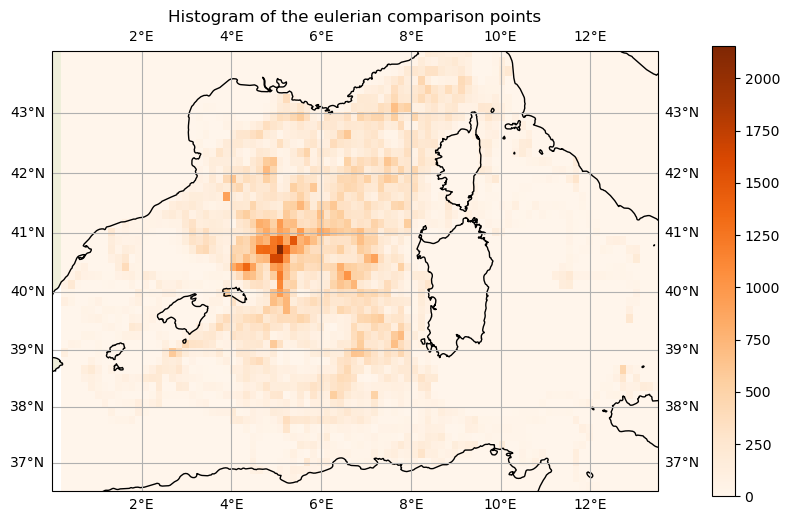

In [9]:
density, lat_edges, lon_edges = np.histogram2d(df.lat.values, df.lon.values, bins=(n_lat, n_lon), range=None, density=False)
plot2d(lon_edges, lat_edges, density, title='Histogram of the eulerian comparison points')

### Compa field/drifter : Velocities L2 norm

In [77]:
compa_norma = (mean_grid['L2_norm_varswot'] - mean_grid['L2_norm_varnadir']) / mean_grid['L2_norm_varnadir']

raw data (without z>3)

In [78]:
compa_norma_wo, idx_outliers = replace_outliers_with_nan_zscore(compa_norma)
compa_norma_wo, idx_outliers = replace_outliers_with_nan_zscore(compa_norma_wo, threshold=3.5)

density_wo = density.copy()
density_wo[idx_outliers] = np.nan

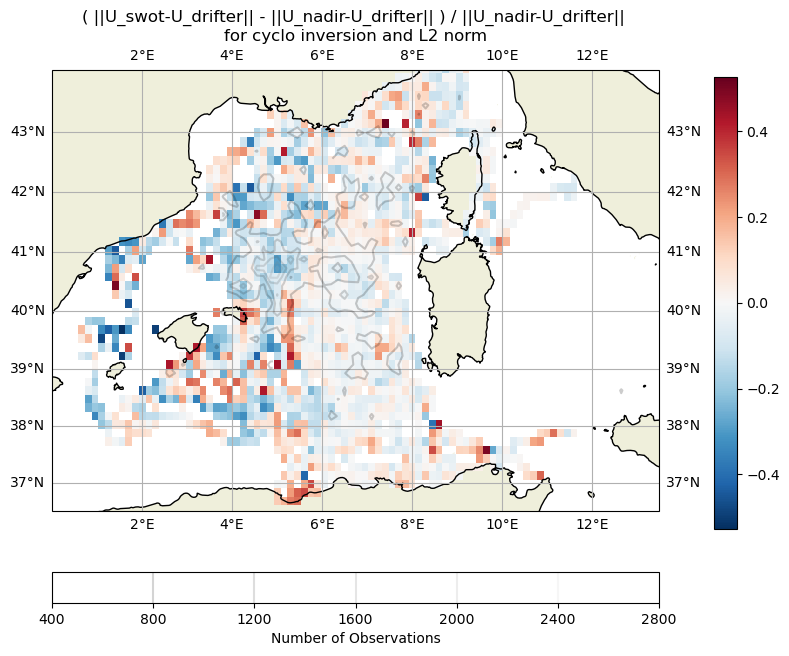

In [79]:
#plot2d(lon_grid, lat_grid, mean_grid['L2_norm_varswot'])
#plot2d(lon_grid, lat_grid, mean_grid['L2_norm_varnadir'])

plot2d_weighted(lon_grid, lat_grid, compa_norma_wo, n_obs=density_wo, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

esperance = -0.027253701845307215


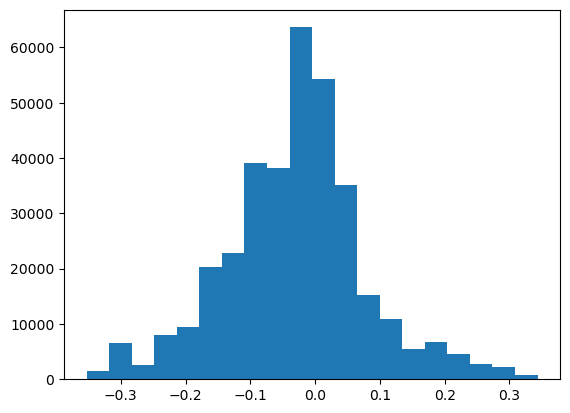

In [80]:
hist, bins, _ = plt.hist( compa_norma_wo.flatten(), weights=density_wo.flatten(), bins=30)

esperance = np.nansum(compa_norma_wo * density_wo / np.nansum(density_wo))
print('esperance =', esperance)

only inside the swath

In [81]:
compa_swath = compa_norma_wo.copy()
compa_swath[~swath_idx] = np.nan

density_swath = density_wo.copy()
density_swath[~swath_idx] = np.nan

compa_swath.shape

(63, 122)

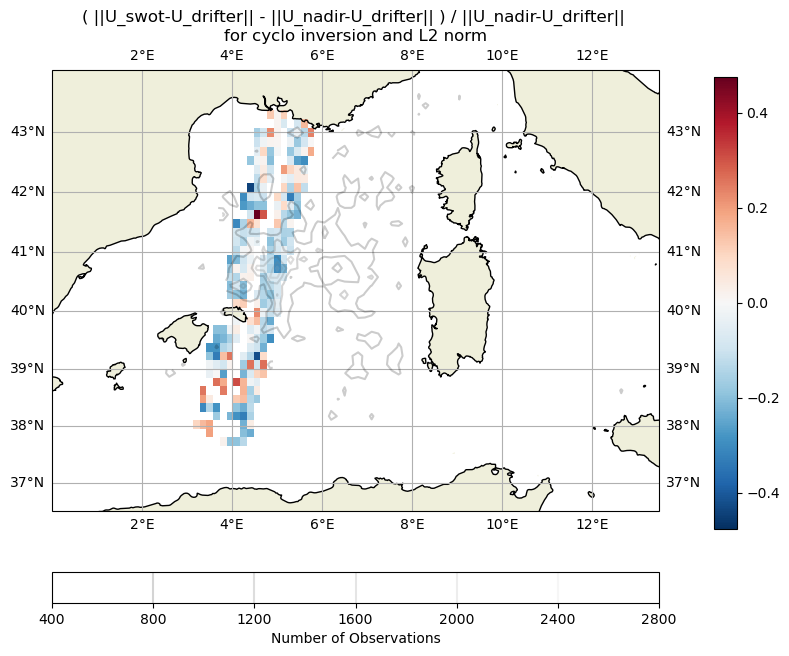

In [82]:
plot2d_weighted(lon_grid, lat_grid, compa_swath, plot_density=True, n_obs=density, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

esperance = -0.09160199082940154


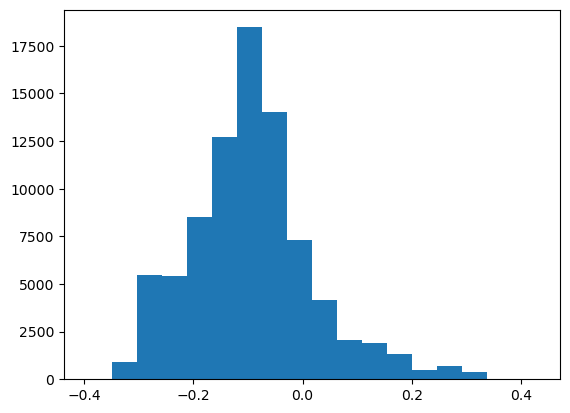

In [84]:
hist, bins, _ = plt.hist( compa_swath.flatten(), weights=density_swath.flatten(), bins=20)

esperance = np.nansum(compa_swath * density_swath / np.nansum(density_swath))
print('esperance =', esperance)

where density > 800

In [106]:
square = (4 <= lon_mesh) & (lon_mesh <= 7) & (39.5 <= lat_mesh) & (lat_mesh <= 41.5)
remove = ~np.logical_and(square, density_wo>500)

compa_select = compa_norma_wo.copy()
compa_select[remove] = np.nan

density_select = density_wo.copy()
density_select[remove] = np.nan

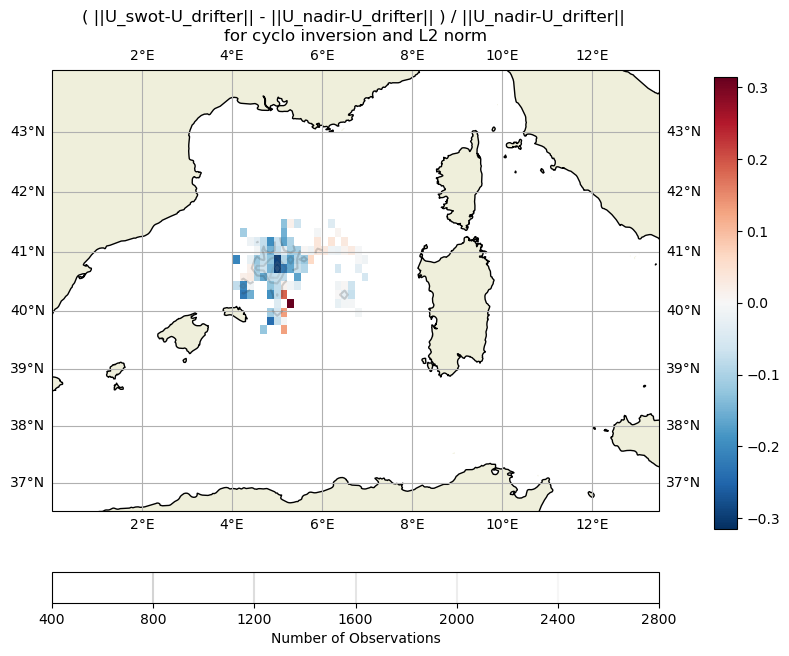

In [107]:
plot2d_weighted(lon_grid, lat_grid, compa_select, plot_density=True, n_obs=density_select, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

esperance = -0.07433698532228736


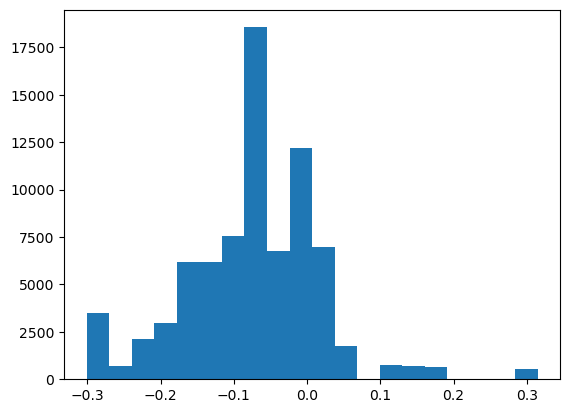

In [108]:
hist, bins, _ = plt.hist( compa_select.flatten(), weights=density_select.flatten(), bins=20)

esperance = np.nansum(compa_select * density_select / np.nansum(density_select))
print('esperance =', esperance)

swath + many observations

In [95]:
select = np.logical_or(~swath_idx, density_wo<300)

compa_select = compa_norma_wo.copy()
compa_select[select] = np.nan

density_select = density_wo.copy()
density_select[select] = np.nan

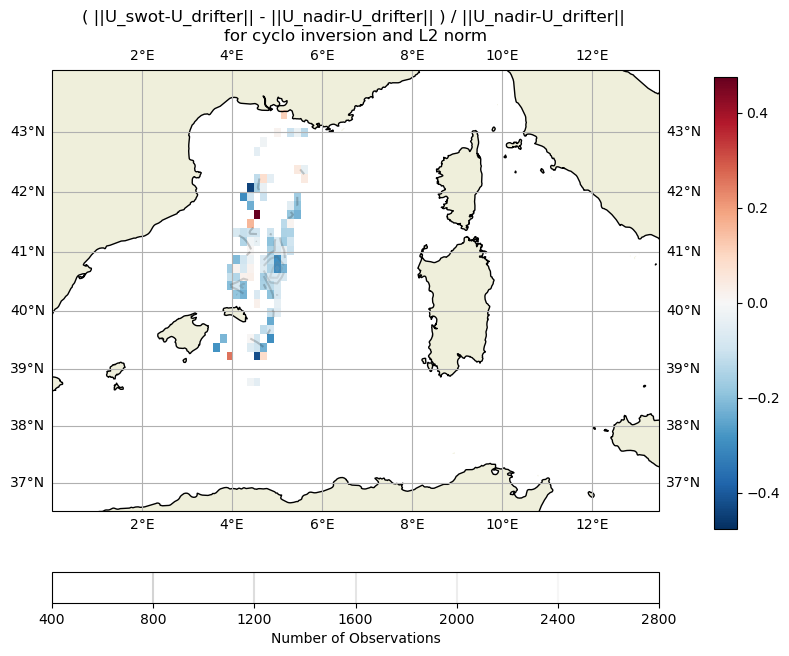

In [96]:
plot2d_weighted(lon_grid, lat_grid, compa_select, plot_density=True, n_obs=density_select, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

esperance = -0.10542597662373394


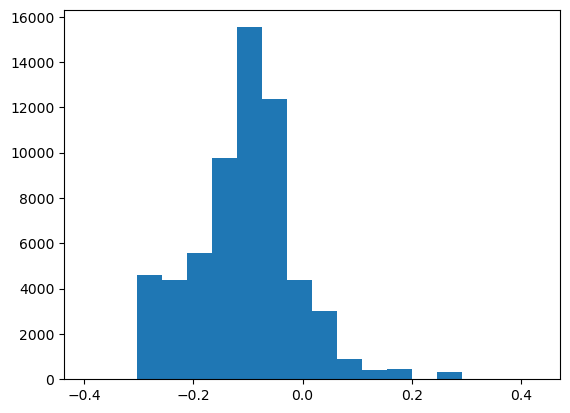

In [97]:
hist, bins, _ = plt.hist( compa_select.flatten(), weights=density_select.flatten(), bins=20)

esperance = np.nansum(compa_select * density_select / np.nansum(density_select))
print('esperance =', esperance)